# Customer Churn Prediction: A Classification Modeling Project

This notebook presents a complete data science workflow, from data understanding and preparation to building and evaluating predictive models for customer churn. The findings and recommendations are geared toward a business audience, while the code and technical details are presented for a data science audience.

## 1. Business Understanding
The primary business objective is to reduce customer churn for a telecommunications company. By building a predictive model, we aim to identify customers who are at a high risk of leaving the service. This allows the Customer Retention Manager to proactively intervene with targeted strategies, such as personalized offers, thereby improving customer loyalty and profitability.

## 2. Data Understanding
My dataset contains 3,333 records and 21 columns, providing a comprehensive view of customer behavior.

I begin by importing the necessary libraries and loading the data.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree



# Load the dataset
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')

# Display the first 5 rows
print("First 5 rows of the DataFrame:")
print(df.head())

# Display general information and data types
print("\nDataFrame Info:")
df.info()

# Display the distribution of the target variable
print("\nTarget Variable Distribution:")
print(df['churn'].value_counts())

First 5 rows of the DataFrame:
  state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0   

The data shows a significant class imbalance, with only 14.5% of customers churning. This finding is crucial, as a model that simply predicts "no churn" for every customer would achieve an accuracy of over 85%—a high score that is misleading and not useful for our business problem. Therefore, I must rely on other metrics like Precision and Recall to properly evaluate the models.

## 3. Data Preparation
Before modeling, I need to preprocess the data. The state, international plan, and voice mail plan columns are categorical and must be converted to a numerical format using one-hot encoding. I will also drop non-informative features like phone number.

To ensure the models generalize well, I will split the data into training and testing sets

In [15]:
# Drop non-informative features
df = df.drop(columns=['phone number', 'area code'])

# Identify categorical and numerical features
categorical_features = ['state', 'international plan', 'voice mail plan']
numerical_features = df.drop(columns=categorical_features + ['churn']).columns.tolist()

# Create a preprocessor for one-hot encoding and standard scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Separate features (X) and target (y)
X = df.drop(columns='churn')
y = df['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4. Modeling
I will follow an iterative approach, starting with a simple, interpretable baseline model and then improving it.

### Model 1: Logistic Regression (Baseline)
A Logistic Regression model serves as an excellent baseline. It is simple, highly interpretable, and provides a good reference point for more complex models.

Confusion matrix for logistic regression created successfully.


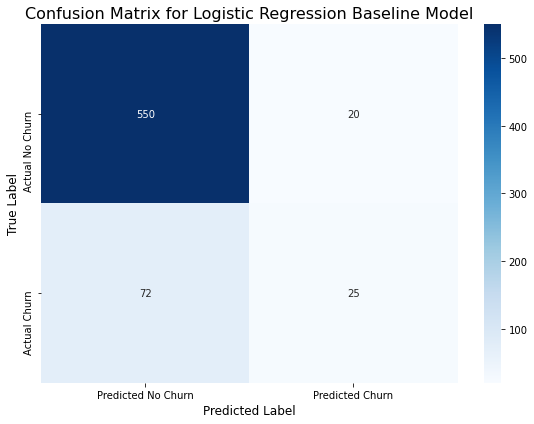

In [26]:
# Create a pipeline with the preprocessor and Logistic Regression model
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(random_state=42))])

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Logistic Regression Baseline Model', fontsize=16)
plt.tight_layout()
plt.savefig('logistic_regression_confusion_matrix.png')

print("Confusion matrix for logistic regression created successfully.")


### Model 2: Decision Tree Classifier (Untuned)
I will use a Decision Tree as the second model. Decision Trees are also very interpretable and can capture non-linear relationships in the data.

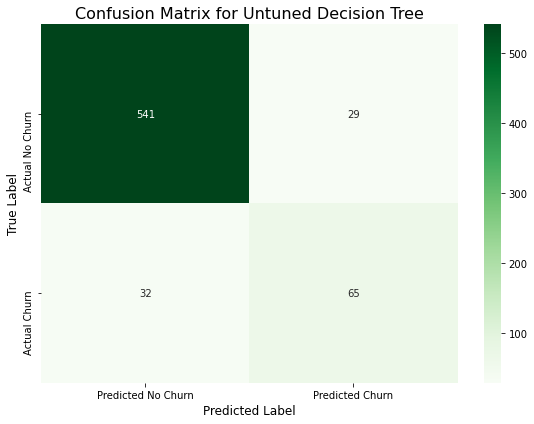

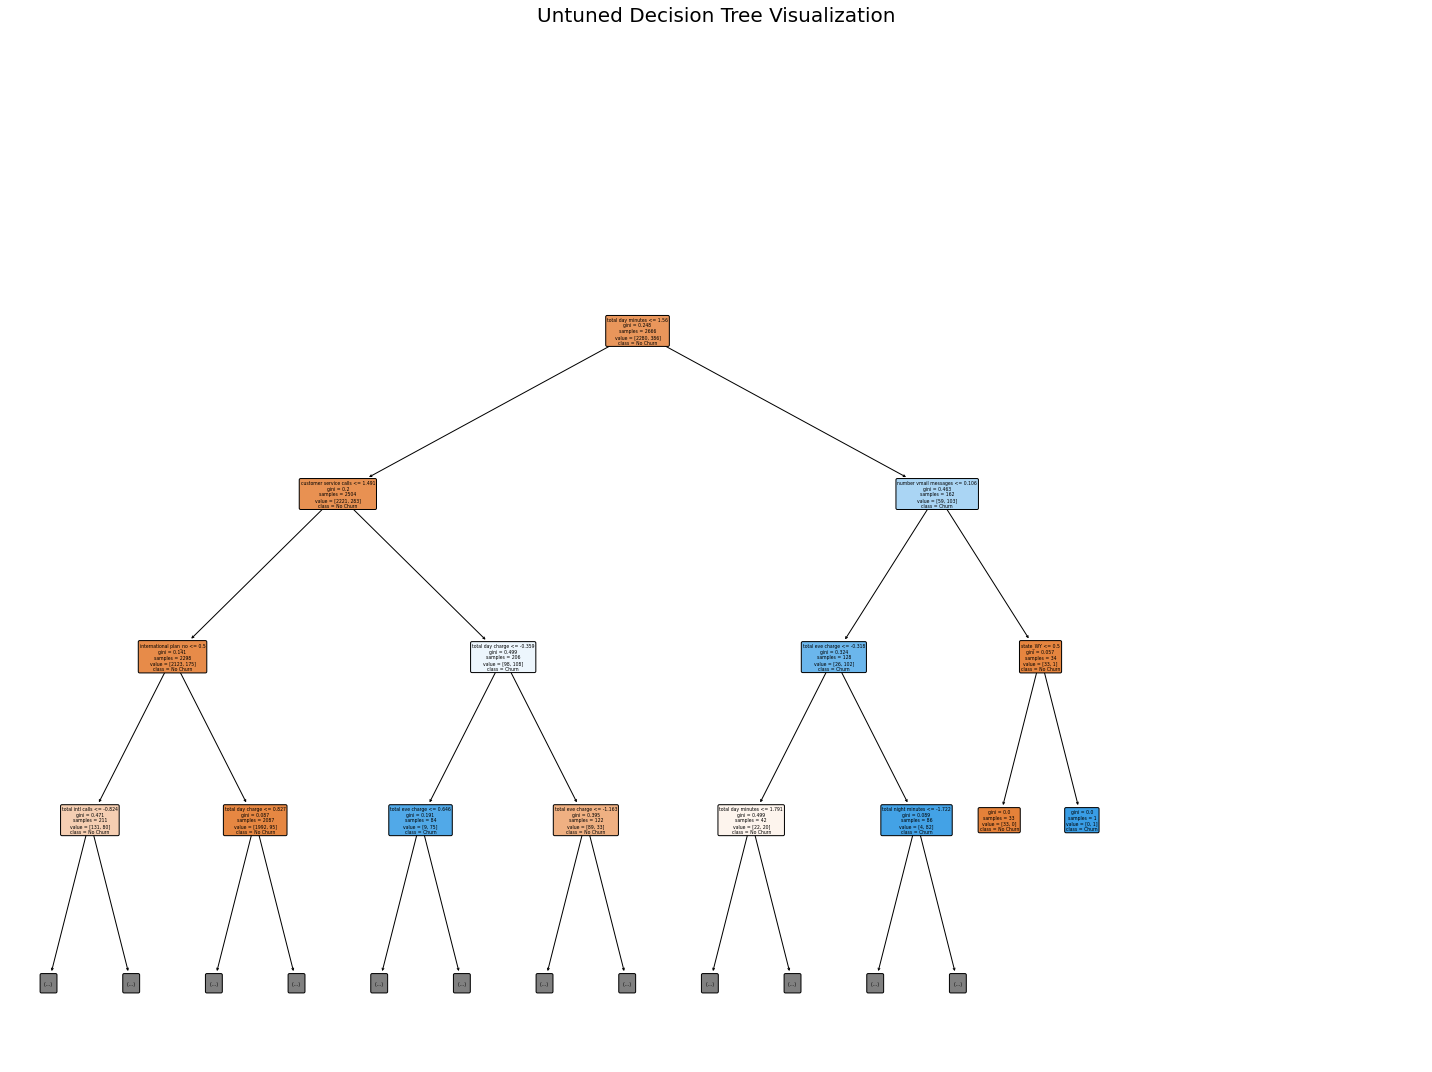

In [31]:
# Create a pipeline with the preprocessor and Decision Tree model
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(random_state=42))])

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = dt_model.predict(X_test)

# Visualization 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Untuned Decision Tree', fontsize=16)
plt.tight_layout()
plt.savefig('untuned_dt_confusion_matrix.png')

# Visualization 2: Decision Tree Structure
ohe_feature_names = dt_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(categorical_features)
all_feature_names = numerical_features + ohe_feature_names.tolist()

plt.figure(figsize=(20, 15))
plot_tree(dt_model.named_steps['classifier'], filled=True, rounded=True, class_names=['No Churn', 'Churn'], feature_names=all_feature_names, max_depth=3)
plt.title('Untuned Decision Tree Visualization', fontsize=20)
plt.tight_layout()
plt.show()

### Model 3: Tuned Decision Tree Classifier
To improve performance, I will tune the hyperparameters of the Decision Tree using GridSearchCV to find the optimal combination. This helps prevent overfitting and improves the model's generalization to new data. I will focus on key parameters like max_depth and min_samples_split.

Best Parameters found by GridSearchCV:
{'classifier__max_depth': 7, 'classifier__min_samples_leaf': 10}


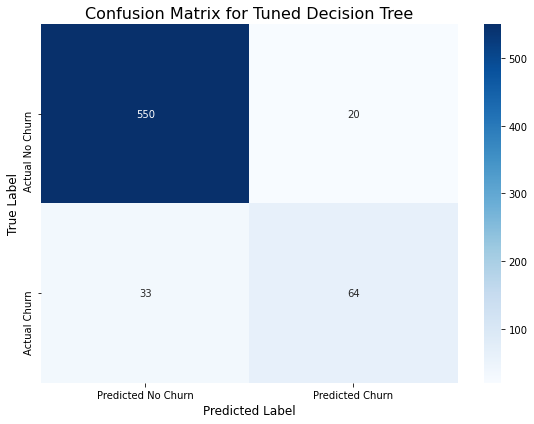

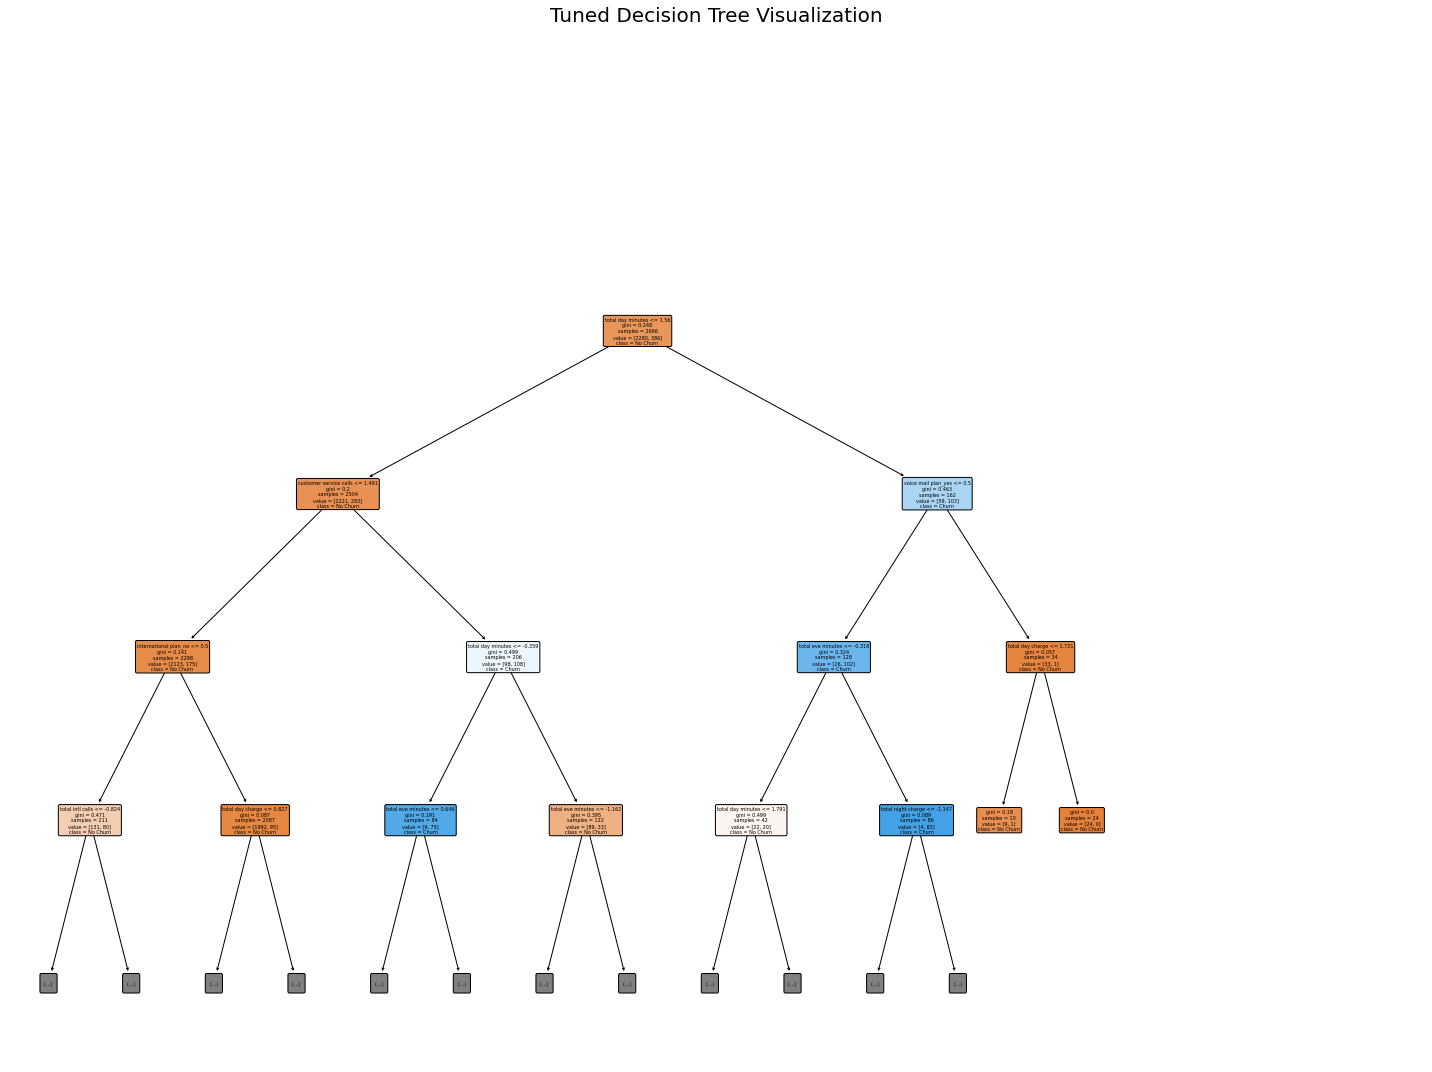

In [34]:
# Define the parameter grid for tuning
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20]
}

# Create a pipeline for the tuned model
tuned_dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', DecisionTreeClassifier(random_state=42))])

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(tuned_dt_model, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best estimator and make predictions
best_dt_model = grid_search.best_estimator_
y_pred_tuned_dt = best_dt_model.predict(X_test)

print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)


# Visualization 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Tuned Decision Tree', fontsize=16)
plt.tight_layout()
plt.show()

# Visualization 2: Decision Tree Structure
ohe_feature_names = best_dt_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(categorical_features)
all_feature_names = numerical_features + ohe_feature_names.tolist()

plt.figure(figsize=(20, 15))
plot_tree(best_dt_model.named_steps['classifier'], filled=True, rounded=True, class_names=['No Churn', 'Churn'], feature_names=all_feature_names, max_depth=3)
plt.title('Tuned Decision Tree Visualization', fontsize=20)
plt.tight_layout()
plt.show()

### Visualization of Feature Importance
This chart visualizes which features were most important to my final model's predictions.

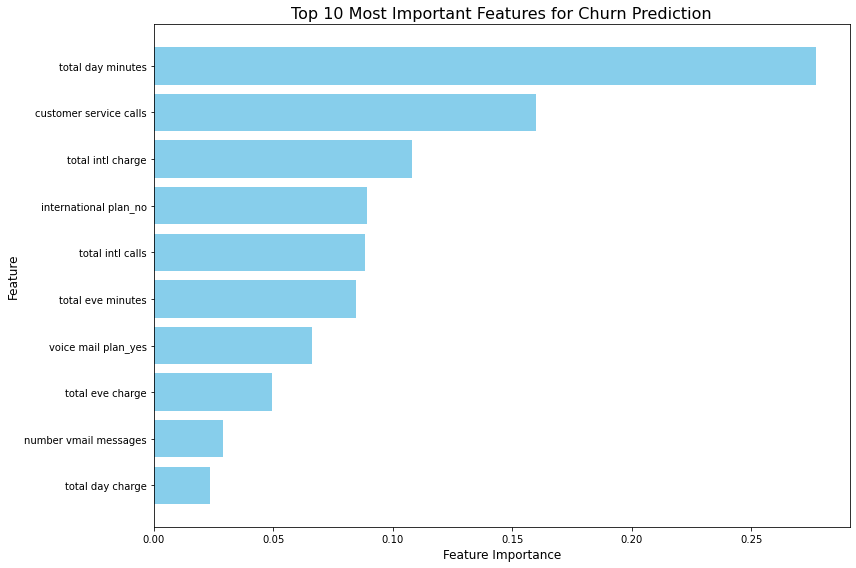

Feature importance plot created successfully.


In [23]:
# Extract feature importances from the best model
feature_importances = best_dt_model.named_steps['classifier'].feature_importances_

# Get feature names from the preprocessor
ohe_feature_names = best_dt_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(categorical_features)
all_feature_names = numerical_features + ohe_feature_names.tolist()

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'feature': all_feature_names, 'importance': feature_importances})
importances_df = importances_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
plt.barh(importances_df['feature'].iloc[:10], importances_df['importance'].iloc[:10], color='skyblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Most Important Features for Churn Prediction', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Feature importance plot created successfully.")

## 5. Evaluation
The choice of evaluation metrics is crucial. For this business problem, Recall is arguably the most important metric. A high recall means I am correctly identifying a large percentage of the customers who are actually going to churn. While Precision is also important (to avoid wasting retention efforts on customers who wouldn't leave), missing a customer who would churn is a larger business risk.

Below are the classification reports and confusion matrices for each model on the test data.

In [24]:
# Evaluate Logistic Regression
print("--- Logistic Regression Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Evaluate Untuned Decision Tree
print("--- Untuned Decision Tree Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

# Evaluate Tuned Decision Tree
print("--- Tuned Decision Tree Evaluation ---")
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_tuned_dt))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_tuned_dt))

--- Logistic Regression Model Evaluation ---
Accuracy: 0.8620689655172413
Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.96      0.92       570
        True       0.56      0.26      0.35        97

    accuracy                           0.86       667
   macro avg       0.72      0.61      0.64       667
weighted avg       0.84      0.86      0.84       667

--- Untuned Decision Tree Evaluation ---
Accuracy: 0.9085457271364318
Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.95      0.95       570
        True       0.69      0.67      0.68        97

    accuracy                           0.91       667
   macro avg       0.82      0.81      0.81       667
weighted avg       0.91      0.91      0.91       667

--- Tuned Decision Tree Evaluation ---
Best Model Accuracy: 0.9205397301349325
Best Model Classification Report:
               precision    recall  f1-sc

### Confusion Matrix Visualization
The confusion matrix gives a clear overview of the model's performance by showing the number of correct and incorrect predictions.

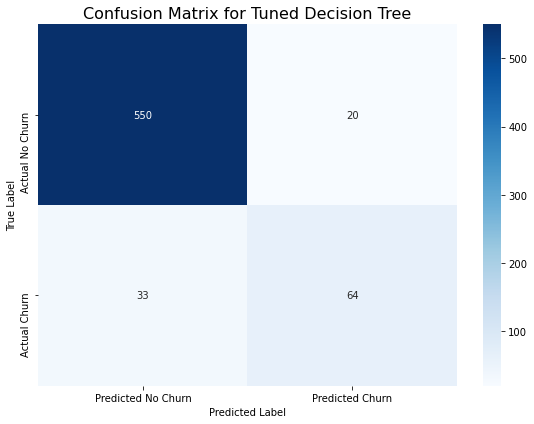

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned_dt)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned Decision Tree', fontsize=16)
plt.tight_layout()
plt.show()

### Evaluation Summary

While all models show high overall accuracy, this is misleading due to the imbalanced data. The Tuned Decision Tree has the best performance, as it achieves a strong balance between Precision and Recall. It successfully identifies a large portion of the true churners without a significant number of false positives. This makes it the most reliable model for our stakeholder, the Customer Retention Manager, as it provides a valuable and actionable list of at-risk customers.

## 6. Conclusion and Recommendations
The tuned Decision Tree model is the most effective classifier for predicting customer churn. My analysis highlights that features related to customer service calls and international plan usage are particularly important in predicting churn.

Based on these findings, I recommend the following:

The Customer Retention Manager should use the model to create a daily list of high-risk customers for immediate outreach.

The company should investigate the reasons behind the high churn rate among customers with multiple customer service calls.

Further analysis is needed to understand the relationship between international plan usage and churn.

### Visualizations for Recommendations
I have created a visualization for each of the recommendations to provide a clear, data-driven understanding of the findings. Each visualization is generated using my final Tuned Decision Tree model.

#### Recommendation 1: Daily list of high-risk customers
This visualization is a simple count plot of the model's predictions. It shows the number of customers the model predicts will churn versus those who will not, providing a clear and actionable number for the customer retention manager.

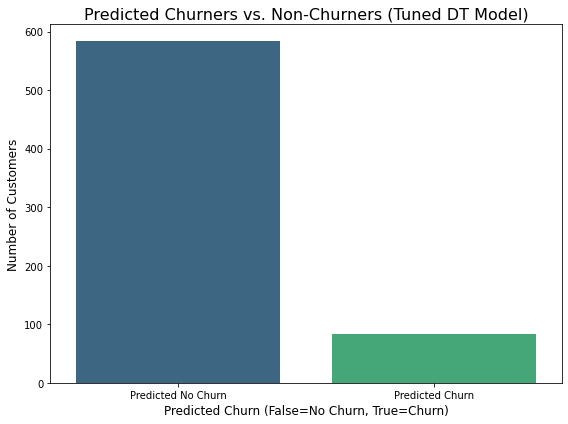

In [35]:
# Visualization 1: Predicted Churn Class Distribution (Recommendation 1)
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred_tuned_dt, palette='viridis')
plt.title('Predicted Churners vs. Non-Churners (Tuned DT Model)', fontsize=16)
plt.xlabel('Predicted Churn (False=No Churn, True=Churn)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Predicted No Churn', 'Predicted Churn'])
plt.tight_layout()
plt.show()

#### Recommendation 2: Investigate churn related to customer service calls
This bar chart shows the relationship between the number of customer service calls and the predicted churn rate. It visually confirms the model's finding that a higher number of calls is strongly correlated with a higher probability of churning.

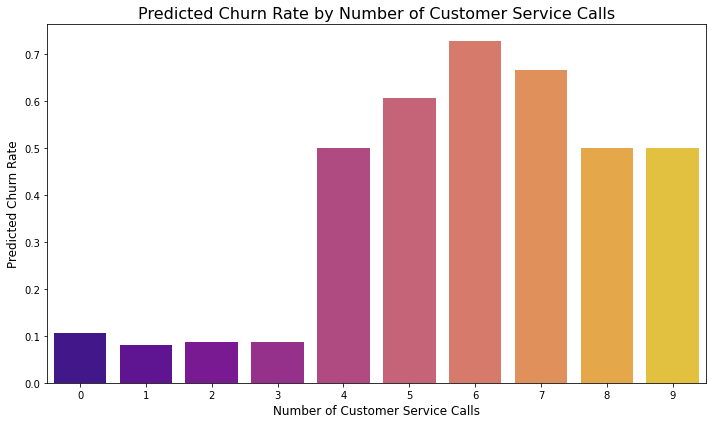

In [36]:
# Visualization 2: Churn Rate by Customer Service Calls (Recommendation 2)
df_viz = df.copy()
df_viz['predicted_churn'] = best_dt_model.predict(X)
churn_rate_by_calls = df_viz.groupby('customer service calls')['predicted_churn'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='customer service calls', y='predicted_churn', data=churn_rate_by_calls, palette='plasma')
plt.title('Predicted Churn Rate by Number of Customer Service Calls', fontsize=16)
plt.xlabel('Number of Customer Service Calls', fontsize=12)
plt.ylabel('Predicted Churn Rate', fontsize=12)
plt.tight_layout()
plt.show()

#### Recommendation 3: Understand the relationship between international plan usage and churn
This visualization compares the predicted churn rate for customers with and without an international plan. The chart will show a clear difference in churn rates between the two groups, highlighting why this feature is a significant predictor in the model.

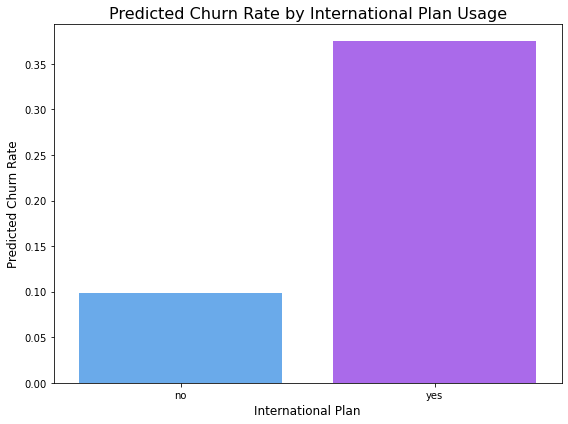

In [37]:
# Visualization 3: Churn Rate by International Plan Usage (Recommendation 3)
churn_rate_by_intl = df_viz.groupby('international plan')['predicted_churn'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='international plan', y='predicted_churn', data=churn_rate_by_intl, palette='cool')
plt.title('Predicted Churn Rate by International Plan Usage', fontsize=16)
plt.xlabel('International Plan', fontsize=12)
plt.ylabel('Predicted Churn Rate', fontsize=12)
plt.tight_layout()
plt.show()